In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
from torch import cuda
from torch.autograd import Variable
import pandas as pd
from skimage import io, transform
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
import seaborn as sns
from pathlib import Path
import pickle
sns.set(color_codes=True)

# Read annotation

## Functions for reading annotations

In [2]:
def read_bboxes(fname):
    img_bbox = {'image_path': [], 'x1': [], 'y1': [], 'x2': [], 'y2': []}
    with open(fname, "r") as file:
        i = 0
        for line in file:
            if i < 2:
                i += 1
            else:
                path, x_1,  y_1,  x_2,  y_2 = line.split()
                img_bbox['image_path'].append(path)
                img_bbox['x1'].append(x_1)
                img_bbox['y1'].append(y_1)
                img_bbox['x2'].append(x_2)
                img_bbox['y2'].append(y_2)
    
    img_bbox = pd.DataFrame(img_bbox)
    img_bbox['x1'] = img_bbox['x1'].astype('int64')
    img_bbox['y1'] = img_bbox['y1'].astype('int64')
    img_bbox['x2'] = img_bbox['x2'].astype('int64')
    img_bbox['y2'] = img_bbox['y2'].astype('int64')
    return img_bbox

In [3]:
def read_categories(fname):
    img_cat = {'image_path': [], 'category': []}
    cat_imgs = {}
    with open(fname, "r") as file:
        i = 0
        for line in file:
            if i < 2:
                i += 1
            else:
                path, cat = line.split()
                img_cat['image_path'].append(path)
                img_cat['category'].append(cat)
                cat_imgs.setdefault(cat, [])
                cat_imgs[cat].append(path)
    img_cat = pd.DataFrame(img_cat)
    img_cat['category'] = img_cat['category'].astype('int64')
    return img_cat, cat_imgs

In [4]:
def read_clothes(fname):
    cloth_cat = {'catname': [], 'category': []}
    with open(fname, "r") as file:
        i = 0
        for line in file:
            if i > 1:
                cloth, _ = line.split()
                cloth_cat['catname'].append(cloth)
                cloth_cat['category'].append(i - 1)
            i += 1
    cloth_cat = pd.DataFrame(cloth_cat)
    cloth_cat['category'] = cloth_cat['category'].astype('int64')
    return cloth_cat

## Get annotations

In [5]:
df_bbox = read_bboxes('dataset/Anno/list_bbox.txt')
df_cat, cat_imgs = read_categories('dataset/Anno/list_category_img.txt')
clothes_cat = read_clothes('dataset/Anno/list_category_cloth.txt')

In [6]:
df_bbox.head(10)

,image_path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,47,67,211,241
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,18,73,200,241
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,75,74,197,246
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,24,56,149,235
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,19,96,192,203


In [7]:
df_cat.head(10)

,image_path,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,3
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,3
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,3
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,3
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,3


In [8]:
clothes_cat.head(10)

,catname,category
0,Anorak,1
1,Blazer,2
2,Blouse,3
3,Bomber,4
4,Button-Down,5
5,Cardigan,6
6,Flannel,7
7,Halter,8
8,Henley,9
9,Hoodie,10


## Merge all results

In [9]:
df = df_bbox.merge(df_cat, on='image_path')
df = df.merge(clothes_cat, on='category')

In [10]:
df.head(10)

,image_path,x1,y1,x2,y2,category,catname
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,3,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,3,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,3,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,3,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,3,Blouse
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,47,67,211,241,3,Blouse
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,18,73,200,241,3,Blouse
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,75,74,197,246,3,Blouse
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,24,56,149,235,3,Blouse
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,19,96,192,203,3,Blouse


## Leave categories of size more than 2000

In [11]:
cat_counts = df['category'].value_counts()
df = df[df['category'].apply(lambda x: cat_counts[x] > 2000)]

## Count number of categories

In [12]:
number_of_categories = len(df['category'].unique())
print('Number of categories:', number_of_categories)

Number of categories: 20


# Identify appropriate size of patches

In [13]:
df_bbox_only = df[['image_path', 'x1', 'y1', 'x2', 'y2']].copy()
df_bbox_only['width'] = df_bbox_only['x2'] - df_bbox_only['x1']
df_bbox_only['height'] = df_bbox_only['y2'] - df_bbox_only['y1']
df_bbox_only.head(10)

,image_path,x1,y1,x2,y2,width,height
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,160,194
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,88,102
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,91,135
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,116,120
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,120,174
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,47,67,211,241,164,174
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,18,73,200,241,182,168
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,75,74,197,246,122,172
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,24,56,149,235,125,179
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,19,96,192,203,173,107


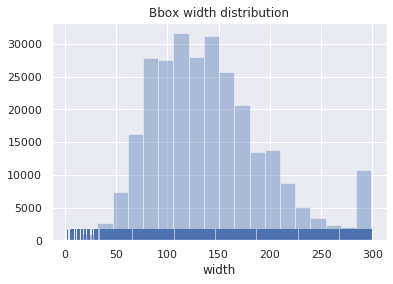

In [14]:
plt.title('Bbox width distribution')
sns.distplot(df_bbox_only['width'], rug=True, kde=False, bins=20)
plt.savefig('bbox_width_hist.png', bbox_inches = 'tight')

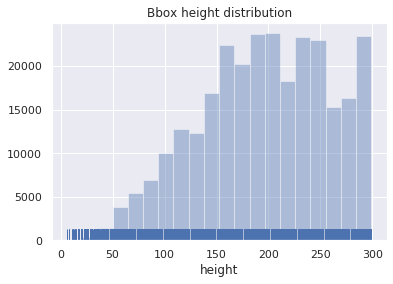

In [15]:
plt.title('Bbox height distribution')
sns.distplot(df_bbox_only['height'], rug=True, kde=False, bins=20)
plt.savefig('bbox_height_hist.png', bbox_inches='tight')

In [16]:
print('Mean bbox width:', df_bbox_only['width'].mean())
print('Mean bbox height:', df_bbox_only['height'].mean())

Mean bbox width: 141.22897824842588
Mean bbox height: 196.1675336290784


## Get image sizes

In [ ]:
count = 0
paths = df_bbox_only['image_path']
prefix = 'dataset/'
total = len(paths)
step = max(5, (total * 5) // 100)
image_sizes = {'image_path': [], 'img_width': [], 'img_height': []}
for path in paths:
    img = io.imread(prefix + path)
    image_sizes['image_path'].append(path)
    image_sizes['img_width'].append(img.shape[1])
    image_sizes['img_height'].append(img.shape[0])
    count += 1
    if count % step == 0:
        print(f'progress: {100 * count / total:.2f}%')

In [ ]:
df_img_size = pd.DataFrame(image_sizes)

In [ ]:
df_img_size.head()

In [ ]:
# cause it tooks a lot of time to compute
df_img_size.to_csv('dataset/image_sizes.csv', index=False)

In [17]:
# just read it from file
df_img_size = pd.read_csv('dataset/image_sizes.csv')
df_img_size.head()

,image_path,img_width,img_height
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,300,300
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,205,300
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,207,300
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,200,250
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,200,300


Print minimum sizes of images

In [18]:
print('Minimum image width:', df_img_size['img_width'].min())
print('Minimum image height', df_img_size['img_height'].min())

Minimum image width: 36
Minimum image height 48


Minimum sizes are too low. We need to investigate further

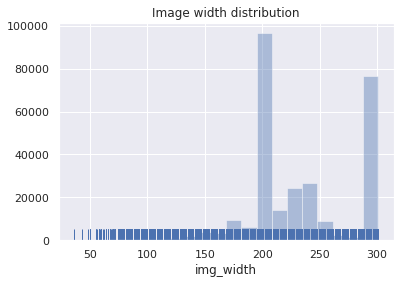

In [19]:
plt.title('Image width distribution')
sns.distplot(df_img_size['img_width'], rug=True, kde=False, bins=20)
plt.savefig('img_width_hist.png', bbox_inches = 'tight')

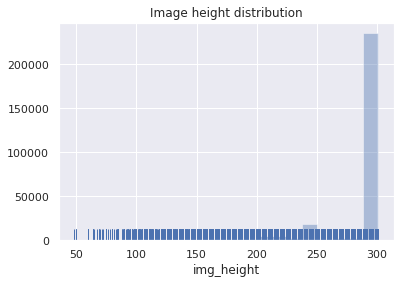

In [20]:
plt.title('Image height distribution')
sns.distplot(df_img_size['img_height'], rug=True, kde=False, bins=20)
plt.savefig('img_height_hist.png', bbox_inches = 'tight')

From these two plots we can see that most of image sizes are significantly more than minimum sizes.<br>
We can get rid of small images, but we need to pay attention to category counts<br>

In [21]:
def category_counts(df):
    result = df['category'].value_counts().to_frame('count')
    result.reset_index(inplace=True)
    result.rename(columns={'index':'category'}, 
                 inplace=True)
    return result

In [22]:
def compare_category_count(cc1, cc2):
    cc1['relative'] = cc2['count'] / cc1['count']
    sns.set_color_codes("pastel")
    sns.barplot('category', 'relative', data=cc1, label='before', color='b')

In [23]:
full_df = df.merge(df_img_size, on='image_path')
full_df = full_df.merge(df_bbox_only.drop(['x1', 'x2', 'y1', 'y2'], axis=1), on='image_path')
full_df.head()

,image_path,x1,y1,x2,y2,category,catname,img_width,img_height,width,height
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,3,Blouse,300,300,160,194
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,3,Blouse,205,300,88,102
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,3,Blouse,207,300,91,135
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,3,Blouse,200,250,116,120
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,3,Blouse,200,300,120,174


In [24]:
# we choose cutoff that are close to mean valuse
width_cutoff = 150
height_cutoff = 200
cut_df = full_df[full_df['img_width'] > width_cutoff]
cut_df = cut_df[cut_df['img_height'] > height_cutoff]
print('deleted images:', len(full_df) - len(cut_df))

deleted images: 15064


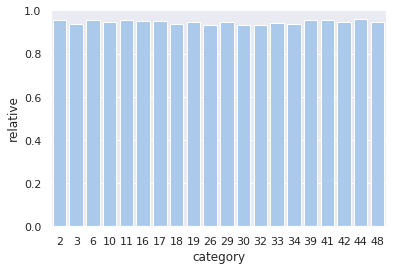

In [25]:
compare_category_count(category_counts(full_df), category_counts(cut_df))

As we can see distribution of classes do not change significantly!

# Show bounding boxes

[67, 59, 155, 161]


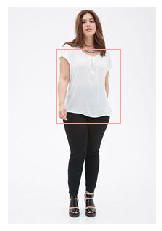

In [26]:
def show_bbox(image, bbox):
    """Show image with bounding box"""
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    x1,  y1,  x2,  y2 = bbox
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, \
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.xticks([]),plt.yticks([])

img_path = df.iloc[1, 0]
bbox = list(df.loc[1, ['x1', 'y1', 'x2', 'y2']])
print(bbox)
show_bbox(io.imread('dataset/' + img_path), bbox)

# Create dataset and dataloader

## Dataset

In [27]:
class ClothesDataset(Dataset):
    """Clothes dataset."""

    def __init__(self, df_dataset, class_to_idx, transform=None, prefix=''):
        self.df_dataset = df_dataset
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.prefix = prefix

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):
        img_path = self.df_dataset.iloc[idx]['image_path']
        img_path = self.prefix + img_path
        image = io.imread(img_path)
        
        category = self.df_dataset.iloc[idx]['category']
        x1,  y1,  x2,  y2 = self.df_dataset.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
        bbox_center = np.array([int(x_center), int(y_center)])
        
        sample = {'image': image, 'category': self.class_to_idx[category], 'bbox_center': bbox_center}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [28]:

class ClothesDatasetOptim(Dataset):
    """Clothes dataset optimized"""

    def __init__(self, dataset_path, class_to_idx, transform=None):
        self.files = [str(Path(dataset_path) / f) for f in os.listdir(dataset_path)]
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'rb') as handle:
            sample = pickle.load(handle)
        if self.transform:
            sample = self.transform(sample)

        return sample

## Transformations

In [29]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (int): Desired output size. Smaller of image edges
            is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, sample):
        image, category, bbox_center = sample['image'], sample['category'], sample['bbox_center']

        h, w = image.shape[:2]
        if h > w:
            new_h, new_w = self.output_size * h / w, self.output_size
        else:
            new_h, new_w = self.output_size, self.output_size * w / h

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bbox_center = bbox_center * [new_w / w, new_h / h]

        return {'image': img, 'category': category, 'bbox_center': bbox_center.astype('int')}

In [30]:
class PatchCrop(object):
    """Crop square patch from image.
    """

    def __init__(self, patch_out_size):
        self.patch_size = patch_out_size # [width, height]

    def __call__(self, sample):
        image, category, bbox_center = sample['image'], sample['category'], sample['bbox_center']
        img_shape = np.array([image.shape[1], image.shape[0]])

        patch_start = bbox_center - np.array(self.patch_size, dtype=np.int32) // 2
        patch_start = np.maximum(patch_start, 0)
        patch_start = np.minimum(patch_start, img_shape - np.array(self.patch_size))
        x1, y1 = patch_start
        x2, y2 = patch_start + self.patch_size
        patch = image[y1:y2, x1:x2]

        return {'image': patch, 'category': category}

In [40]:
class Hog(object):
    """Crop square patch from image.
    """

    def __init__(self):
        pass

    def __call__(self, sample):
        image, category = sample['image'], sample['category']
        hog_features = hog(image, multichannel=True)
        
        return {'hog': hog_features, 'category': category}

In [41]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        hog, category = sample['hog'], sample['category']

        hog = hog.astype('float32')
        return {'hog': torch.from_numpy(hog),
                'category': category}

In [42]:
def save_dataset(dataset, dst):
    count = 0
    total = len(dataset)
    step = max(5, (total / 10) // 100)
    for i in range(len(dataset)):
        with open(dst + f'{i}.pickle', 'wb') as handle:
            pickle.dump(dataset[i], handle, protocol=pickle.HIGHEST_PROTOCOL)
        count += 1
        if count % step == 0:
            print(f'progress: {count * 100 / total:.2f}%', end='\r')

## Train test split

In [43]:
df_train, df_test = train_test_split(cut_df, test_size=0.20, shuffle=True, stratify=cut_df['category'])

In [44]:
patch_width = 145
patch_height = 195

In [45]:
classes = cut_df['category'].unique()
indices = np.arange(0, len(classes), dtype=np.int64)
class_to_idx = {k: v for k, v in zip(classes, indices)}
train0 = ClothesDataset(df_train, class_to_idx
                       , prefix='dataset/')
train = ClothesDataset(df_train, class_to_idx,
                       transform=transforms.Compose([
                           PatchCrop([patch_width, patch_height]),
                           Hog(),
                           ToTensor()
                       ]), prefix='dataset/')
test = ClothesDataset(df_test, class_to_idx,
                       transform=transforms.Compose([
                           PatchCrop([patch_width, patch_height]),
                           Hog(),
                           ToTensor()
                       ]), prefix='dataset/')

In [46]:
save_dataset(test, 'dataset/ds_hog/test/')

In [ ]:
save_dataset(train, 'dataset/ds_hog/train')

In [ ]:
test_optim = ClothesDatasetOptim('dataset/ds_hog/test/', class_to_idx)
train_optim = ClothesDatasetOptim('dataset/ds_hog/train/', class_to_idx)

In [ ]:
print('train size:', len(train_optim))
print('test_size:', len(test_optim))

In [ ]:
%%timeit
test_optim[30]

In [ ]:
idx = 9000
plt.imshow(train[idx]['image'])
print(train[idx]['category'])
plt.show()
show_bbox(train0[idx]['image'], df_train.iloc[idx][['x1', 'y1', 'x2', 'y2']])

In [ ]:
%%timeit
train0[8090]

In [ ]:
for i in range(len(train)):
    sample = train[i]

    print(f'#{i}:', sample['hog'].size(), sample['category'])
    if i == 0:
        input_dim = list(sample['hog'].size())[0]

    if i == 3:
        break

In [ ]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

In [ ]:
batch_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [ ]:
output_dim = number_of_categories
lr_rate = 0.01
epochs = 100

model = LogisticRegression(input_dim, output_dim)
if train_on_gpu:
    model = model.to('cuda')
if multi_gpu:
    model = nn.DataParallel(model)

In [ ]:
# trainiter = iter(train_loader)
# sample = next(trainiter)
# sample['hog'].size(), sample['category']

In [ ]:
# model(sample['hog'])

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [ ]:
%%timeit
data = iter(train_loader)
s = next(data)

In [ ]:
%%timeit
features = Variable(s['hog'])
labels = Variable(s['category'])
if train_on_gpu:
    features = features.cuda()
    labels = labels.cuda()
optimizer.zero_grad()
outputs = model(features)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

In [ ]:
iteration = 0
for epoch in range(epochs):
    model.train()
    start = timer()
    for i, sample in enumerate(train_loader):
        features = Variable(sample['hog'])
        labels = Variable(sample['category'])
        if train_on_gpu:
            features = features.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(
                f'Epoch: {epoch}\t{100 * (i + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
        iteration+=1
        if iteration % 500 == 0:
            # calculate Accuracy
            correct = 0
            total = 0
            for sample in test_loader:
                features = Variable(sample['hog'])
                labels = Variable(sample['category'])
                if train_on_gpu:
                    features = features.cuda()
                    labels = labels.cuda()
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu for python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iteration, loss.item(), accuracy))